Importar librerias

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
#paquete para manejar varable de entorno(variable q esta en otra parte del codigo)
from dotenv import load_dotenv
import os

In [28]:
#Desactivar warnings
import warnings
warnings.filterwarnings('ignore')

Conexión a Base de datos

In [ ]:
import os

def cargar_variables_entorno(archivo):
    # Abrir el archivo de texto con las variables
    with open(archivo, 'r') as file:
        # Leer cada línea y configurar las variables de entorno
        for line in file:
            # Limpiar posibles saltos de línea y separar la clave y valor
            clave, valor = line.strip().split('=')
            os.environ[clave] = valor  # Establecer la variable de entorno

# Llamar a la función con el archivo config.txt
cargar_variables_entorno('C:\\Users\\Public\\PF\\config.txt')

# Ahora puedes acceder a las variables de entorno
host = os.getenv('HOST')
dbName = os.getenv('DB_NAME')
port = int(os.getenv('PORT'))  # Asegúrate de convertir a entero si es necesario
user = os.getenv('USER')
pswd = os.getenv('PASSWORD')

print(f"Host: {host}, DB Name: {dbName}, Port: {port}, User: {user}, Password: {pswd}")

In [30]:
user = os.getenv('USER')
pswd = os.getenv('PASSWORD')
host = os.getenv('HOST')
dbName = os.getenv('DB_NAME')
port = int(os.getenv('PORT'))

try:
    connection = pymysql.connect(host = host, user = user, passwd = pswd, database = dbName, port = port)
    cursor = connection.cursor()
    print (cursor) # Muestra el cursor si todo funciona correctamente

except pymysql.Error as e:
    print("Error en la conexión:", e)

Creacion de los df para realizar EDA

In [31]:
#Tabla aircrafts
query = "SELECT * FROM aircrafts_data;"
aircrafts_data = pd.read_sql_query(query, connection)

#Tabla airports
query = "SELECT * FROM airports_data;"
airports_data = pd.read_sql_query(query, connection)

#Tabla boarding_passes
query = "SELECT * FROM boarding_passes;"
boarding_passes = pd.read_sql_query(query, connection)

#Tabla bookings
query = "SELECT * FROM bookings;"
bookings = pd.read_sql_query(query, connection)

#Tabla flights
query = "SELECT * FROM flights;"
flights = pd.read_sql_query(query, connection)

#Tabla seats
query = "SELECT * FROM seats;"
seats = pd.read_sql_query(query, connection)

#Tabla ticket_flights
query = "SELECT * FROM ticket_flights;"
ticket_flights = pd.read_sql_query(query, connection)

#Tabla tickets
query = "SELECT * FROM tickets;"
tickets = pd.read_sql_query(query, connection)

Estadistica descriptiva

In [32]:
# Configurar el formato de visualización para evitar notación científica y mostrar dos decimales
pd.options.display.float_format = '{:.2f}'.format

In [33]:
#Estadistica descriptiva montos en tabla bookings
bookings['total_amount'].describe()

count    262788.00
mean      79025.61
std       77621.92
min        3400.00
25%       29000.00
50%       55900.00
75%       99200.00
max     1204500.00
Name: total_amount, dtype: float64

In [34]:
#Estadistica descriptiva montos en tabla ticket_flights
ticket_flights['amount'].describe()

count   1045726.00
mean      19858.91
std       22612.39
min        3000.00
25%        7200.00
50%       13400.00
75%       23100.00
max      203300.00
Name: amount, dtype: float64

- Rango de las aeronaves

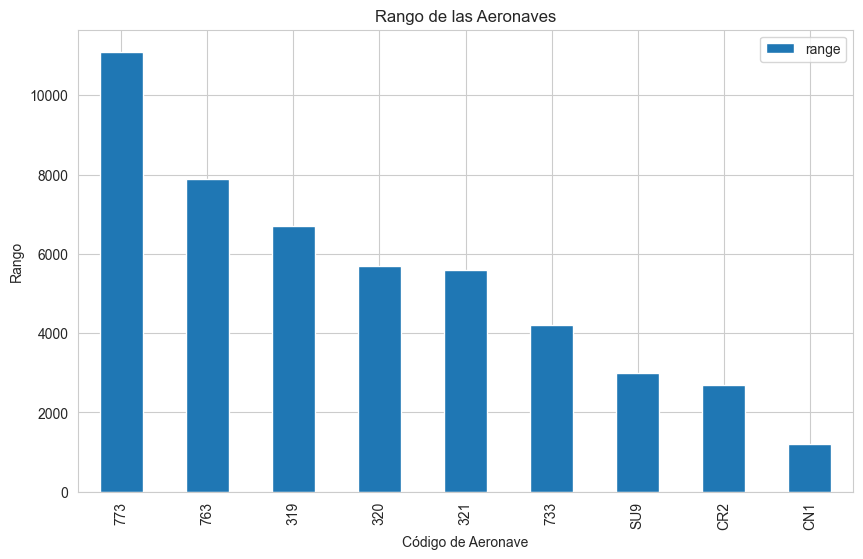

In [35]:
# Seleccionar las columnas necesarias del DataFrame
columnas_seleccionadas = aircrafts_data[['aircraft_code', 'range']]

# Ordenar las columnas por 'range' de mayor a menor
columnas_seleccionadas = aircrafts_data[['aircraft_code', 'range']].sort_values(by='range', ascending=False)

# Realizar el gráfico de barras
sns.set_style("whitegrid")  # Configurar el estilo
columnas_seleccionadas.plot(kind='bar', x='aircraft_code', y='range', figsize=(10, 6))

# Configuración general del gráfico
plt.xlabel('Código de Aeronave')
plt.ylabel('Rango')
plt.title('Rango de las Aeronaves')
plt.show()

El rango del aeronave representa el alcance en kilometros. El 773, es un avion de fuselaje ancho para vuelos largos. El A320, por ejemplo, es de fuselaje angosto para vuelos de mediano radio. Y el CR2, son aviones pequeños de vuelos regionales.

- Cantidad de asientos por clase

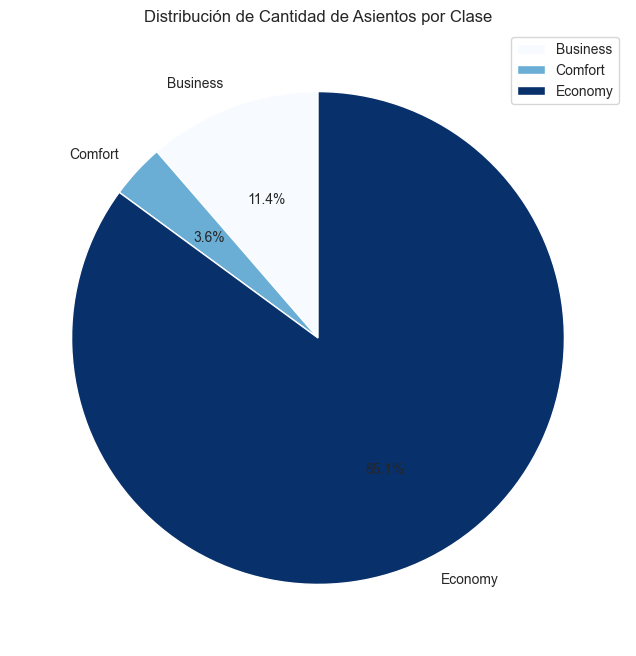

In [36]:
#Agrupar aeronave por fare_conditions 
aeronave_clase= seats.groupby('fare_conditions')['seat_no'].count()

plt.figure(figsize=(8, 8))
aeronave_clase.plot.pie(
    autopct='%1.1f%%',  # Mostrar porcentaje
    startangle=90,      # Comenzar desde la parte superior
    cmap='Blues',       # Paleta de colores
    legend=True         # Agregar leyenda
)

# Configuración del gráfico
plt.ylabel('')  # Eliminar etiqueta del eje Y
plt.title('Distribución de Cantidad de Asientos por Clase')
plt.show()

El total de asientos en todas las aeronaves se distribuye: el 85.1% pertenecen a la clase Economy, un 11.4% a Business y un 3.6% a Comfort.

- Aeropuertos por zona horaria

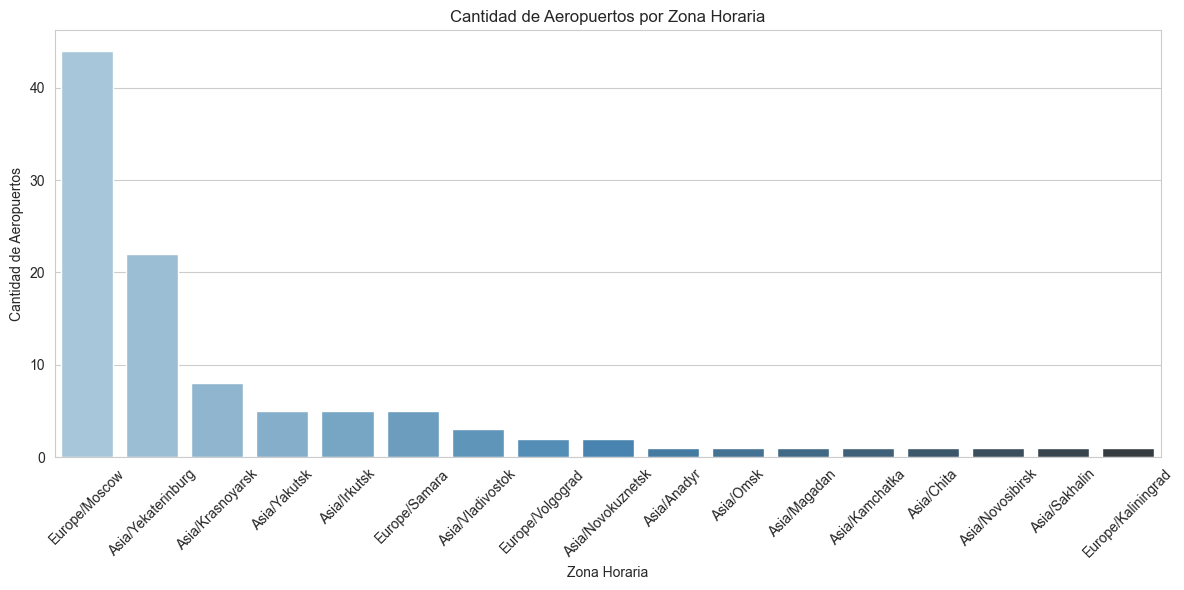

In [37]:
# Agrupar por 'timezone' y contar los 'airport_code'
airport_counts = airports_data.groupby('timezone')['airport_code'].count().reset_index()

# Renombrar la columna para mayor claridad
airport_counts.rename(columns={'airport_code': 'count'}, inplace=True)

# Ordenar los datos por cantidad de aeropuertos
airport_counts = airport_counts.sort_values(by='count', ascending=False)

# Crear el barplot
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=airport_counts, x='timezone', y='count', palette='Blues_d')

# Configuración del gráfico
plt.xlabel('Zona Horaria')
plt.ylabel('Cantidad de Aeropuertos')
plt.title('Cantidad de Aeropuertos por Zona Horaria')
plt.xticks(rotation=45)  # Rotar etiquetas si hay muchas zonas horarias
plt.tight_layout()
plt.show()


Hay 44 aeropuertos ubicados en la zona de Moscu, 22 en Yekaterinburg, 8 en Krasnoyarsk y 5 en Yakutsk, en Irkutsk y en Samara.

- Evolucion semanal Monto total de Reservas

In [38]:
# Conversion de la columna de date a datetime
bookings['book_date'] = pd.to_datetime(bookings['book_date'])
bookings.set_index('book_date', inplace=True) # Inplace para que se pise asimismo

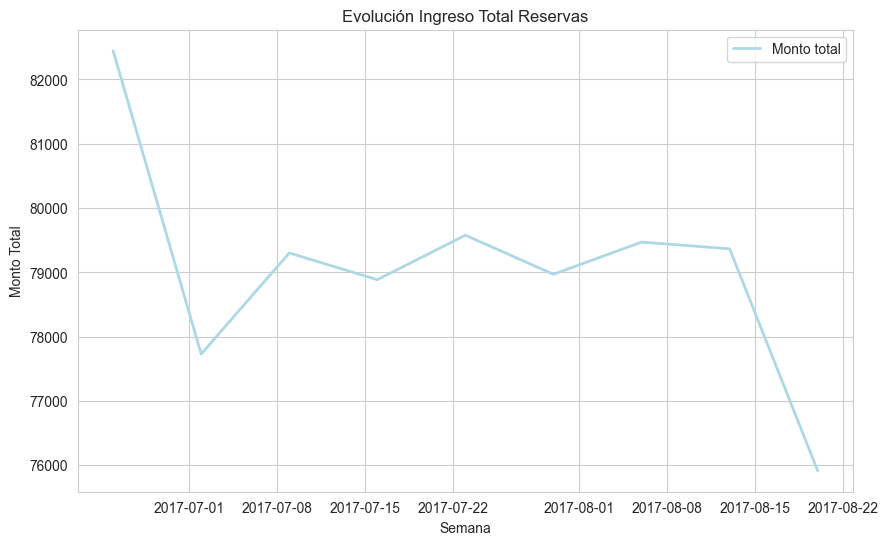

In [39]:
# Resampleo semanal y cálculo de la media
bookings_resampled = bookings.resample('W').mean(numeric_only=True).reset_index()

# Crear gráfico de líneas
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.lineplot(data=bookings_resampled, x='book_date', y='total_amount', 
             label='Monto total', color='lightblue', linewidth=2)

# Configuración general del gráfico
plt.xlabel('Semana')
plt.ylabel('Monto Total')
plt.title('Evolución Ingreso Total Reservas')
plt.legend()
plt.show()


- Evolucion semanal Ingresos Totales Tickets

In [40]:
bookings.reset_index(inplace=True)  # Restaurar 'book_date' como columna

# Relacionar bookings y tickets partir de book_ref
df_bookings_tickets = bookings.merge(tickets, on='book_ref', how='inner')

# Seleccionar columnas
df_bookings_tickets = df_bookings_tickets[['book_ref', 'book_date', 'ticket_no']]

# Mostrar el df resultante
print(df_bookings_tickets)

       book_ref           book_date   ticket_no
0        00000F 2017-07-05 03:12:00  5435838975
1        000012 2017-07-14 09:02:00  5432527326
2        000068 2017-08-15 14:27:00  5432293273
3        000181 2017-08-10 13:28:00  5435545944
4        000181 2017-08-10 13:28:00  5435545945
...         ...                 ...         ...
366728   FFFF43 2017-07-20 20:42:00  5433986163
366729   FFFF43 2017-07-20 20:42:00  5433986164
366730   FFFFA8 2017-08-08 04:45:00  5435426293
366731   FFFFF7 2017-07-01 22:12:00  5434343796
366732   FFFFF7 2017-07-01 22:12:00  5434343797

[366733 rows x 3 columns]


In [41]:
# Relacionar df_bookings_tickets y tickets_flight partir de ticket_no
df_booking_tickets_tflights = df_bookings_tickets.merge(ticket_flights, on='ticket_no', how='inner')

# Seleccionar columnas
df_booking_tickets_tflights = df_booking_tickets_tflights[['book_ref', 'book_date', 'ticket_no', 'fare_conditions', 'amount']]

# Mostrar el df resultante
print(df_booking_tickets_tflights)

        book_ref           book_date   ticket_no fare_conditions  amount
0         00000F 2017-07-05 03:12:00  5435838975         Economy   66400
1         00000F 2017-07-05 03:12:00  5435838975        Business  199300
2         000012 2017-07-14 09:02:00  5432527326         Economy   14000
3         000012 2017-07-14 09:02:00  5432527326         Comfort   23900
4         000068 2017-08-15 14:27:00  5432293273         Economy   10200
...          ...                 ...         ...             ...     ...
1045721   FFFFF7 2017-07-01 22:12:00  5434343796         Economy   14400
1045722   FFFFF7 2017-07-01 22:12:00  5434343797         Economy   14400
1045723   FFFFF7 2017-07-01 22:12:00  5434343797         Economy    4000
1045724   FFFFF7 2017-07-01 22:12:00  5434343797         Economy    4000
1045725   FFFFF7 2017-07-01 22:12:00  5434343797         Economy   14400

[1045726 rows x 5 columns]


In [42]:
# Conversion de la columna de date a datetime
df_booking_tickets_tflights['book_date'] = pd.to_datetime(df_booking_tickets_tflights['book_date'])
df_booking_tickets_tflights.set_index('book_date', inplace=True) # Inplace para que se pise asimismo

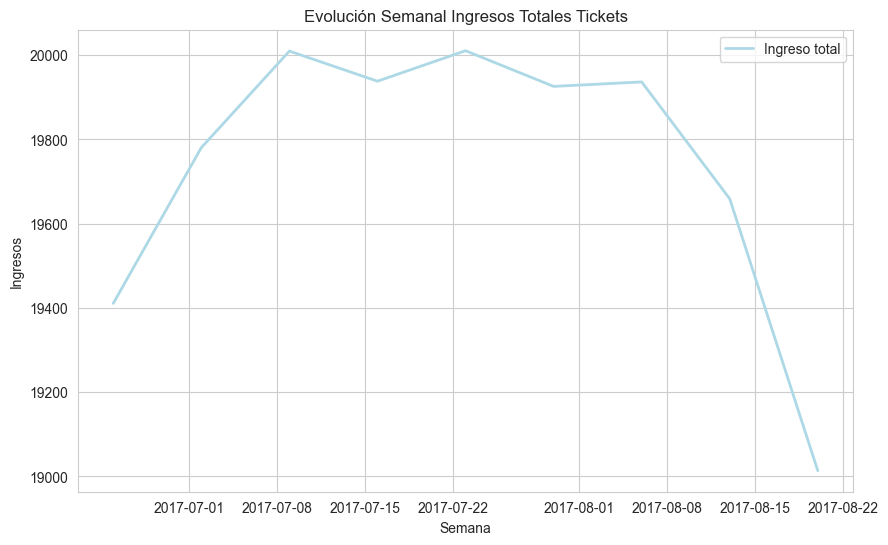

In [43]:
# Resampleo semanal y cálculo de la media
df_booking_tickets_tflights_resampled = df_booking_tickets_tflights.resample('W').mean(numeric_only=True).reset_index()

# Crear gráfico de líneas
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.lineplot(data=df_booking_tickets_tflights_resampled, x='book_date', y='amount', 
             label='Ingreso total', color='lightblue', linewidth=2)

# Configuración general del gráfico
plt.xlabel('Semana')
plt.ylabel('Ingresos')
plt.title('Evolución Semanal Ingresos Totales Tickets')
plt.legend()
plt.show()

- Evolución de Ingresos por Condición de Tarifa

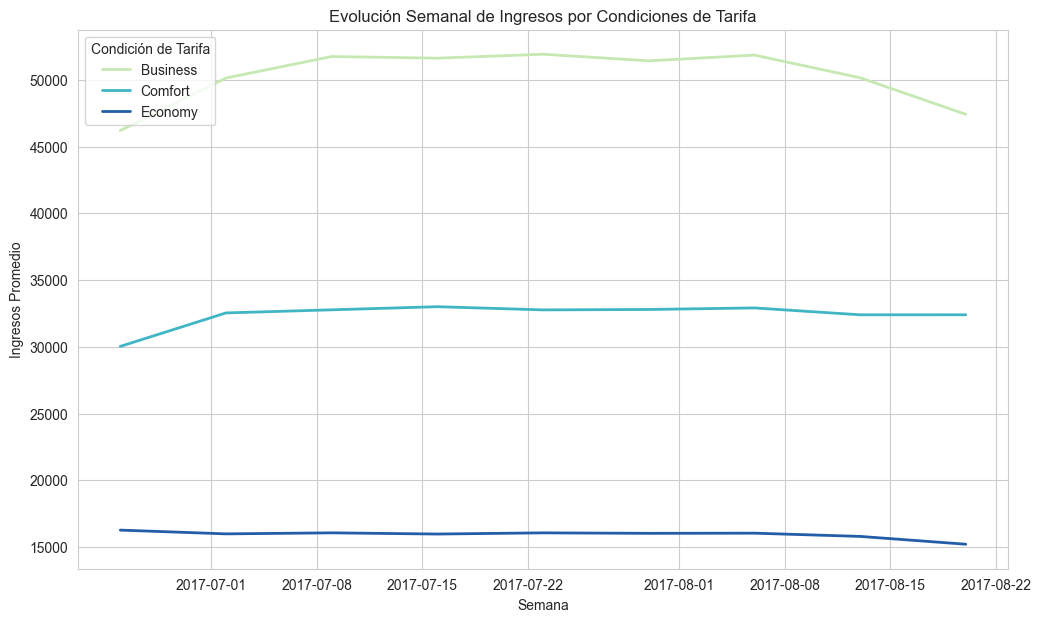

In [51]:
# Resampleo semanal y cálculo de la media, agrupando por 'fare_conditions'
df_resampled = (
    df_booking_tickets_tflights
    .groupby('fare_conditions')  # Agrupar por fare_conditions
    .resample('W')['amount']    # Resampleo semanal para calcular la media
    .mean()
    .reset_index()
)

# Crear gráfico de líneas con hue para diferenciar las condiciones de tarifa
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

sns.lineplot(data=df_resampled, x='book_date', y='amount', hue='fare_conditions',
             palette='YlGnBu', linewidth=2)

# Configuración general del gráfico
plt.xlabel('Semana')
plt.ylabel('Ingresos Promedio')
plt.title('Evolución Semanal de Ingresos por Condiciones de Tarifa')
plt.legend(title='Condición de Tarifa')
plt.show()

- Ingresos Totales por Condicion de Tarifa

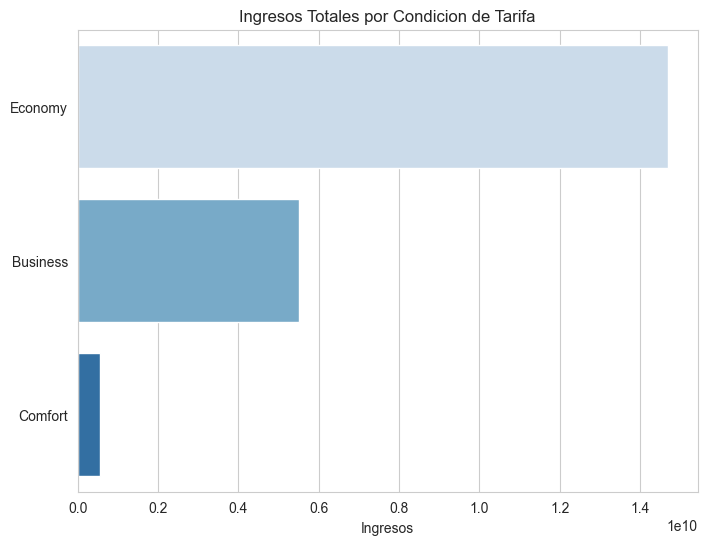

In [55]:
# Agrupar por fare_conditions y calcular la suma de amount
fare_conditions_suma = ticket_flights.groupby('fare_conditions')['amount'].sum().reset_index()

# Ordenar por columna amount
fare_conditions_suma = fare_conditions_suma.sort_values('amount', ascending=False)

# Crear el gráfico de barras horizontal
plt.figure(figsize=(8, 6))
sns.barplot(data=fare_conditions_suma, y='fare_conditions', x='amount', palette='Blues')

# Configuración del gráfico
plt.title('Ingresos Totales por Condicion de Tarifa')
plt.ylabel('')
plt.xlabel('Ingresos')
plt.show()

- Ingreso Promedio por Condicion de Tarifa

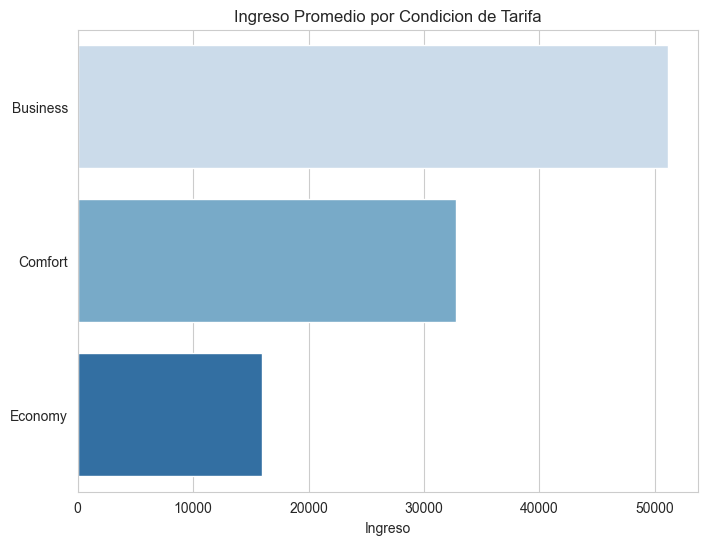

In [54]:
# Agrupar por fare_conditions y calcular promedio de amount
fare_conditions_promedio = ticket_flights.groupby('fare_conditions')['amount'].mean().reset_index()

# Ordenar de mayor a menor por la columna 'amount'
fare_conditions_promedio = fare_conditions_promedio.sort_values('amount', ascending=False)

# Crear el gráfico de barras horizontal
plt.figure(figsize=(8, 6))
sns.barplot(data=fare_conditions_promedio, y='fare_conditions', x='amount', palette='Blues')

# Configuración del gráfico
plt.title('Ingreso Promedio por Condicion de Tarifa')
plt.ylabel('')
plt.xlabel('Ingreso')
plt.show()

- Distribución de Vuelos por Estado

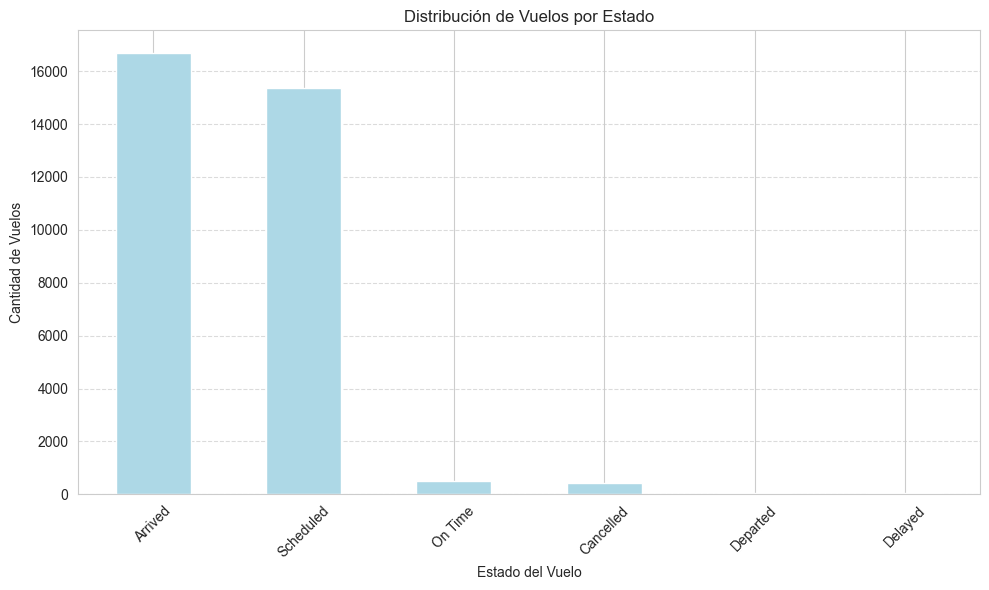

In [60]:
# Agrupación de vuelos por status y orden descendente
flight_status = flights.groupby('status')['flight_id'].count().sort_values(ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
flight_status.plot.bar(
    color='lightblue'  
    )

# Configuración del gráfico
plt.xlabel('Estado del Vuelo') 
plt.ylabel('Cantidad de Vuelos')  
plt.title('Distribución de Vuelos por Estado')  
plt.xticks(rotation=45)  
plt.grid(axis='y', linestyle='--', alpha=0.7)  

# Mostrar el gráfico
plt.tight_layout()
plt.show()

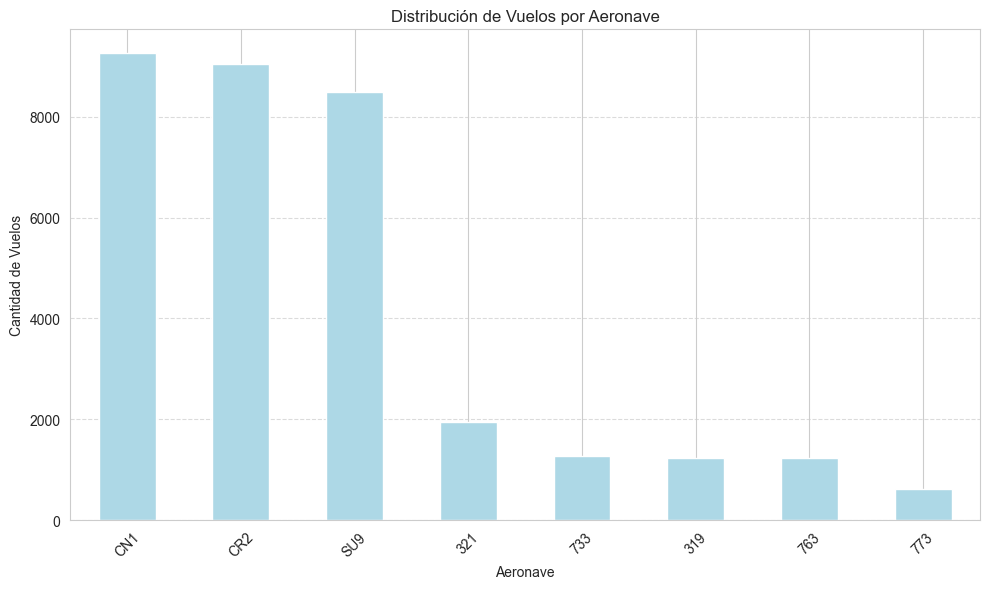

In [61]:
# Agrupación de vuelos por status y orden descendente
flight_aircraft = flights.groupby('aircraft_code')['flight_id'].count().sort_values(ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
flight_aircraft.plot.bar(
    color='lightblue'  
    )

# Configuración del gráfico
plt.xlabel('Aeronave') 
plt.ylabel('Cantidad de Vuelos')  
plt.title('Distribución de Vuelos por Aeronave')  
plt.xticks(rotation=45)  
plt.grid(axis='y', linestyle='--', alpha=0.7)  

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [ ]:
# Relacionar flights y ticket_flights a partir de la columna 'flight_id'
df_flights_ticketf = flights.merge(ticket_flights, on='flight_id', how='inner')

# Mostrar el DataFrame resultante
print(df_relacionado)

         flight_id flight_no scheduled_departure   scheduled_arrival  \
0                1    PG0405 2017-07-16 09:35:00 2017-07-16 10:30:00   
1                1    PG0405 2017-07-16 09:35:00 2017-07-16 10:30:00   
2                1    PG0405 2017-07-16 09:35:00 2017-07-16 10:30:00   
3                1    PG0405 2017-07-16 09:35:00 2017-07-16 10:30:00   
4                1    PG0405 2017-07-16 09:35:00 2017-07-16 10:30:00   
...            ...       ...                 ...                 ...   
1045721      33121    PG0063 2017-08-26 19:25:00 2017-08-26 20:10:00   
1045722      33121    PG0063 2017-08-26 19:25:00 2017-08-26 20:10:00   
1045723      33121    PG0063 2017-08-26 19:25:00 2017-08-26 20:10:00   
1045724      33121    PG0063 2017-08-26 19:25:00 2017-08-26 20:10:00   
1045725      33121    PG0063 2017-08-26 19:25:00 2017-08-26 20:10:00   

        departure_airport arrival_airport     status aircraft_code  \
0                     DME             LED    Arrived           32